In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Reading the csv file and observing the data
import pandas as pd

df = pd.read_csv('account_fraud.csv')
df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [19]:
# Creating dummy variables from categorical columns
df =  pd.get_dummies(df, prefix=['payment_type', 'employment_status', 'housing_status', 'source', 'device_os'],
                     columns=['payment_type', 'employment_status','housing_status', 
                              'source', 'device_os'])



In [20]:
#creating correlation matrix
import numpy as np
correlation_matrix = df.corr() 

In [21]:
 #Creating a correlation matrix of booleans based on whether the absolute value is greater than .9
# and then getting the indices.
threshold = .9
[(i, n) for i,n in zip(*np.where(np.abs(correlation_matrix.values) > threshold)) if i!=n]

[(46, 47), (47, 46)]

In [22]:
# Dropping source_TELEAPP from dataset
df = df.drop(['source_TELEAPP'], axis=1)

In [23]:
from sklearn.model_selection import train_test_split

# x data is all independent variables, and target is fraud_bool
x_data = df.drop(['fraud_bool'], axis=1) 
target_data = df['fraud_bool']
# splitting the data using sklearn
# using 20% as test size
x_train, x_test, target_train, target_test = train_test_split(x_data, target_data, test_size=0.2, random_state=42)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

mm_scaler = MinMaxScaler()
log_reg = LogisticRegression()

# Using pipeline to add minmax scaler
pipeline = Pipeline([("scaler", mm_scaler), ("classifier", log_reg)])


In [25]:
from sklearn.metrics import accuracy_score 
# fitting the pipeline model
pipeline.fit(x_train, target_train)
# using the accuracy_score to get the model's accuracy
predictions = pipeline.predict(x_test)
accuracy = accuracy_score(target_test, predictions)
print('Model accuracy: ', accuracy)

Model accuracy:  0.989495


## F1 Score

In [26]:
# Calculating F-1 score, confusion matrix, ROC curve, and K-Fold cross validation
from sklearn.metrics import f1_score

f_1_score = f1_score(target_test, predictions, average='weighted')
print('F1 score ', f_1_score)

F1 score  0.9844365623298004


### Interpretation
The F1 score can be interpreted as the mean of precision and recall. Recall is how often the model correctly identifies positive instances. In our case how often a fraudulent transaction was detected (or non-fraudulent). Therefore the closer to 1 the F1 score, the better. As we can see this model has a great F1 score at .98.

## Confusion Matrix

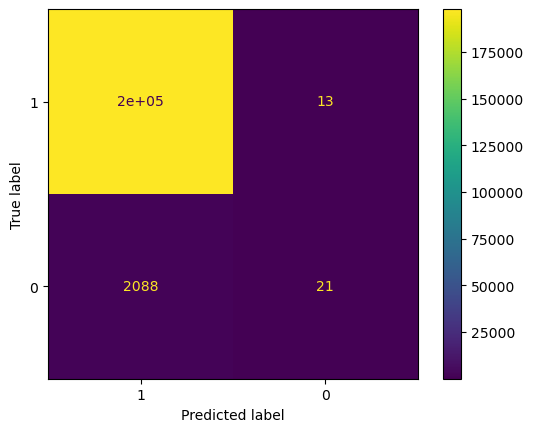

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt
confusion_matrix = metrics.confusion_matrix(target_test, predictions)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 0])

cm_display.plot()
plt.show()

### Interpretation
The confusion matrix shows us the predicted true and false values versus the actual true and false values. The top left tells us the correct true predictions, the top right shows us false positives, the bottom left shows us false negatives, and the bottom right shows us true negatives. As we can see our largest number is where we want in, in the top left under true positive predictions.

## ROC Curve

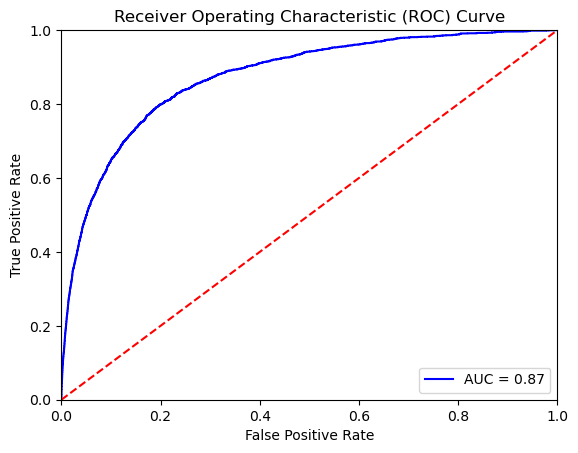

In [28]:
import scikitplot as skplt
probability = pipeline.predict_proba(x_test)
predictions = probability[:,1]
flase_pos, true_pos, threshold = metrics.roc_curve(target_test, predictions)
roc_auc = metrics.auc(flase_pos, true_pos)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(flase_pos, true_pos, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Interpretation
The ROC curve shows us the rate a model predicts the true outcome correctly versus incorrectly. The more area under the curve the better. As we can see based off of the ROC-Curve the model performed well.

In [29]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(x_data)

def run_kfold_cv():
    # prepare the cross-validation procedure
    cross_val = KFold(n_splits=10, random_state=1, shuffle=True)

    scores = cross_val_score(pipeline, X_minmax, target_data, scoring='accuracy', cv=cross_val, n_jobs=-1)
    # report performance by getting mean of performances
    print('Accuracy: ', mean(scores))
    
    
run_kfold_cv()

/Users/troyquicksall/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/troyquicksall/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Accuracy:  0.989025


/Users/troyquicksall/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Interpretation
Cross-validation is useful to estimate the success of a machine learning model on unseen data. This means to use a limited sample in order to measure how the model is expected to perform on data not used to train the model. As we can see the model performed well during cross-validation.